In [1]:
# Generic python libraries
import os
import math
import random
from PIL import Image
from pathlib import Path
from random import sample
from skimage.transform import rotate
from skimage.draw import rectangle_perimeter
from skimage import io, transform, util, color, img_as_uint, img_as_ubyte


# PyTorch and numpy related
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchgeometry as tgm
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50

In [2]:
def toUINT8(image):     
    image[image<0]=0
    image[image>255]=255
#     image[((image>0) & (image<=42))] = 0
#     image[((image>42) & (image<85))] = 85
#     image[((image>85) & (image<=127))] = 85
#     image[((image>127) & (image<170))] = 170
#     image[((image>170) & (image<=212))] = 170
#     image[((image>212) & (image<255))] = 255
    image = image.astype(np.uint8, copy=False)
    return image

In [3]:
def rotate_and_save(img, mask_img, angle, img_filename, mask_filename):
    img = rotate(img,angle,resize=False,preserve_range=True)
    mask_img = rotate(mask_img,angle,resize=False,preserve_range=True)
    io.imsave(img_filename,toUINT8(img),check_contrast=False)
    io.imsave(mask_filename,toUINT8(mask_img),check_contrast=False)


In [4]:
# # AUGMENT DATASET SECTION
# ##  for Each Dataset type
# ##  for Each image inside images folder 
# ##  Generate Single image with all masks overlapped
# ##  Generate multiple variations of the images based on 
# ##  Rotations and axis flips

# ROOT_DATASET_PATH = "/home/humberto/src/Univ/DATASETS/SpermSegGS"
# DATASET_TYPES = ["train", "test"]
# MASK_FOLDERS = ["Head-Masks", "Midpiece-Masks", "Tail-Masks"]
# DESTINATION_BASE_FOLDER = "Processed"
# ROTATION_ANGLES = range(0, 181, 5)
# CLASS_COLOR_MAP = {0: 0, 1:85, 2:170, 3: 255}


# for dataset_type in DATASET_TYPES:
#     current_image_dir = os.path.join(ROOT_DATASET_PATH,'images',dataset_type)
#     current_mask_dir = os.path.join(ROOT_DATASET_PATH,'mask')
#     processed_image_path = os.path.join(ROOT_DATASET_PATH,DESTINATION_BASE_FOLDER,'images',dataset_type)
#     processed_mask_image_path = os.path.join(ROOT_DATASET_PATH,DESTINATION_BASE_FOLDER,'mask',dataset_type)
    
#     Path(processed_image_path).mkdir(parents=True, exist_ok=True)
#     Path(processed_mask_image_path).mkdir(parents=True, exist_ok=True)
    
#     image_file_list = os.listdir(current_image_dir)
#     for image_file in image_file_list:
#         image = toUINT8(io.imread(os.path.join(current_image_dir, image_file)))
#         masks = []
#         for current_mask in MASK_FOLDERS:
#             masks.append(np.expand_dims(toUINT8(io.imread(os.path.join(current_mask_dir, current_mask, image_file))),axis=-1))
#         background = np.ones(masks[0].shape,dtype=masks[0].dtype)*16
#         joint_mask = np.argmax(np.concatenate((background,masks[0],masks[1],masks[2]),axis=-1),axis=-1)
# #         joint_mask[joint_mask >= 0] = [CLASS_COLOR_MAP[x] for x in joint_mask[joint_mask >= 0]]
        
#         for angle in ROTATION_ANGLES:
#             img_path = os.path.join(processed_image_path,str(angle)+"_0_"+image_file)
#             mask_path = os.path.join(processed_mask_image_path,str(angle)+"_0_"+image_file.split(".")[0]+".bmp")
#             rotate_and_save(image,joint_mask,angle,img_path,mask_path)

#             v_image = np.flip(image, axis= 0)
#             v_joint_mask = np.flip(joint_mask, axis= 0)
#             img_path = os.path.join(processed_image_path,str(angle)+"_V_"+image_file)
#             mask_path = os.path.join(processed_mask_image_path,str(angle)+"_V_"+image_file.split(".")[0]+".bmp")
#             rotate_and_save(v_image,v_joint_mask,angle,img_path,mask_path)
            
            random
#             h_image = np.flip(image, axis= 1)
#             h_joint_mask = np.flip(joint_mask, axis= 1)
#             img_path = os.path.join(processed_image_path,str(angle)+"_H_"+image_file)
#             mask_path = os.path.join(processed_mask_image_path,str(angle)+"_H_"+image_file.split(".")[0]+".bmp")
#             rotate_and_save(h_image,h_joint_mask,angle,img_path,mask_path)

In [4]:
class SegmentationDataset(VisionDataset):
    def __init__(self,image_folder,mask_folder):
        self.image_folder_path = image_folder
        self.mask_folder_path = mask_folder
        self.image_names = os.listdir(image_folder)
        self.mask_names = os.listdir(mask_folder)
        self.image_names.sort()
        self.mask_names.sort()
        
        self.image_transform_pipeline = transforms.Compose([
            transforms.Resize((580,780)),
#             transforms.CenterCrop(500),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.mask_transform_pipeline = transforms.Compose([
            transforms.Resize((580,780)),
#             transforms.CenterCrop(500)
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder_path,self.image_names[index])
        mask_path = os.path.join(self.mask_folder_path,self.mask_names[index])
        with open(image_path, "rb") as image_file, open(mask_path,"rb") as mask_file:
            image = Image.open(image_file).convert("RGB")
            mask = Image.open(mask_file).convert("L")
            image = self.image_transform_pipeline(image)
            mask = torch.as_tensor(toUINT8(np.array(self.mask_transform_pipeline(mask)))).unsqueeze(0)
            return image, mask, index

In [5]:
TRAIN_IMAGE_FOLDER_PATH = "/home/humberto/src/Univ/DATASETS/SpermSegGS/Processed/images/train"
TRAIN_MASK_FOLDER_PATH = "/home/humberto/src/Univ/DATASETS/SpermSegGS/Processed/mask/train"

############################################################################################

TEST_IMAGE_FOLDER_PATH = "/home/humberto/src/Univ/DATASETS/SpermSegGS/Processed/images/test"
TEST_MASK_FOLDER_PATH = "/home/humberto/src/Univ/DATASETS/SpermSegGS/Processed/mask/test"

In [6]:
train_dataset = SegmentationDataset(TRAIN_IMAGE_FOLDER_PATH,TRAIN_MASK_FOLDER_PATH)

In [65]:
len(train_dataset)

1665

In [7]:
t_img_2 = train_dataset[350][1]
t_img_2.unique()
# t_img_2[t_img_2!= 0 | t_img_2!= 85 | t_img_2!= 170 | t_img_2!= 255] = 0
# transforms.functional.to_pil_image(t_img_2).show()

# for i in range(t_img_2.size()[1]):
#     for j in range(t_img_2.size()[2]):
#         print(i, j,t_img_2[0][i][j])
        
# print(t_img_2.unique(),t_img_2, t_img_2.size())

tensor([0, 1, 2, 3], dtype=torch.uint8)

In [8]:
def BuildCustomDeeplab(num_classes, pretrained=True):
    model = deeplabv3_resnet50(pretrained=pretrained)
    model.classifier = DeepLabHead(2048, num_classes)
    return model

In [74]:
def test(data, network, criterion, criterion2, device):
    network.eval()
    loss_c = 0
    iou_c = 0
    dice_loss_c = 0
    flag = False
    with torch.no_grad():
        for input, target, idx in data:
            input = input.to(device)
            target = target.to(device).view(target.size()[0],target.size()[2],target.size()[3]).long()
            output = model(input)["out"]
            normalized_masks = torch.nn.functional.softmax(output, dim=1)
            class_argmax = normalized_masks.argmax(dim=1)
            
            iou_c += iou_pytorch(class_argmax,target).item()
            dice_loss_c += criterion2(output,target).item()
            loss_c += criterion(output,target).item()
            
            if not flag and random.random() < 0.3:
                flag = True
                
                dog_and_boat_masks = [
                    normalized_masks[img_idx, sem_class_to_idx[cls]]
                        for img_idx in range(input.size()[0])
                        for cls in ['__background__']
                ]
                
                show(dog_and_boat_masks)
                
                dog_and_boat_masks = [
                    normalized_masks[img_idx, sem_class_to_idx[cls]]
                        for img_idx in range(input.size()[0])
                        for cls in ['head']
                ]
                
                show(dog_and_boat_masks)
                
                dog_and_boat_masks = [
                    normalized_masks[img_idx, sem_class_to_idx[cls]]
                        for img_idx in range(input.size()[0])
                        for cls in ['body']
                ]
                
                show(dog_and_boat_masks)
                
                dog_and_boat_masks = [
                    normalized_masks[img_idx, sem_class_to_idx[cls]]
                        for img_idx in range(input.size()[0])
                        for cls in ['tail']
                ]
                
                show(dog_and_boat_masks)
    return loss_c, iou_c, dice_loss_c
            
def train(data, network, optimizer, criterion, criterion2, device):
    network.train()
    loss_c = 0
    for input, target, idx in data:
        input = input.to(device)
        target = target.to(device).view(target.size()[0],target.size()[2],target.size()[3]).long()
        optimizer.zero_grad()
        output = network(input)["out"]
#         l1 = criterion(output, target)
#         l2 = criterion2(output, target)
#         loss = (0.8 * l1) + (0.2 * l2)
        loss = criterion(output, target)
        loss_c += loss.item()
        loss.backward()
        optimizer.step()
    return loss_c

In [11]:
def run_train_epochs(network, train_dataset, optimizer, criterion, criterion2=None, scheduler=None, epochs=10, batch_size=5, device='cuda', collate=None):
    network.to(device)
    train_data = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate)
    train_loss, train_acc = [], []
    for e in range(1,epochs+1):
        temp_train_loss = train(train_data, network, optimizer, criterion, criterion2, device)
        train_loss.append(temp_train_loss/len(train_dataset)*batch_size)
        print(f"Epoch: {e} \n Train | loss: {train_loss[-1]:.5f} ")

In [12]:
def run_test_epochs(network, test_dataset, criterion, criterion2=None, batch_size=5, device='cuda', collate=None):
    network.to(device)
    test_data = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate)
    test_loss, test_iou, test_dice = test(test_data,network,criterion,criterion2,device)
    
    test_loss = test_loss/len(test_dataset)*batch_size
    test_iou = test_iou/len(test_dataset)*batch_size
    test_dice = test_dice/len(test_dataset)*batch_size
    
    print(f"TEST | loss: {test_loss:.5f} | IoU: {test_iou:.5f} | Dice: {test_dice:.5f}")       

In [12]:
# criterion = nn.CrossEntropyLoss()
# criterion2 = tgm.losses.DiceLoss()
# model = BuildCustomDeeplab(4, True)
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [13]:
# run_epochs(model,train_dataset,None,optimizer,criterion,criterion2)

/home/humberto/miniconda3/envs/ttest/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 
 Train | loss: 0.09639 
Epoch: 2 
 Train | loss: 0.04380 
Epoch: 3 
 Train | loss: 0.03999 
Epoch: 4 
 Train | loss: 0.03756 
Epoch: 5 
 Train | loss: 0.03561 
Epoch: 6 
 Train | loss: 0.03487 
Epoch: 7 
 Train | loss: 0.03392 
Epoch: 8 
 Train | loss: 0.03258 
Epoch: 9 
 Train | loss: 0.03189 
Epoch: 10 
 Train | loss: 0.03142 


In [14]:
# torch.save(model,"model_trained_25_without_colors_deeplabv3.pt")

In [15]:
# torch.save(model,"deeplabv3_batch5_epochs10_normalized_pretrained.pt")

In [149]:
model = torch.load("deeplabv3_batch5_epochs10_unnormalized_notpretrained.pt")

In [150]:
import matplotlib.pyplot as plt
# plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(10.0,10.0))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [151]:
test_dataset = SegmentationDataset(TEST_IMAGE_FOLDER_PATH,TEST_MASK_FOLDER_PATH)

In [152]:
len(test_dataset)

444

In [153]:
sem_classes = ['__background__', 'head', 'body', 'tail']
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

In [154]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
#     print(outputs.size(), labels.size())
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     print("Int", intersection)
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
#     print("Uni", union)
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou.mean() 

TEST | loss: 0.81401 | IoU: 0.00000 | Dice: 0.02474


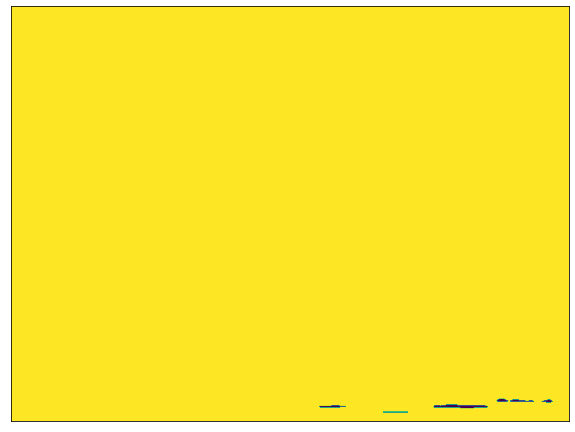

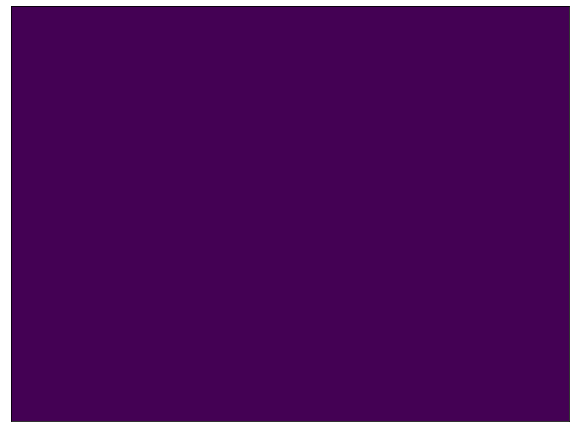

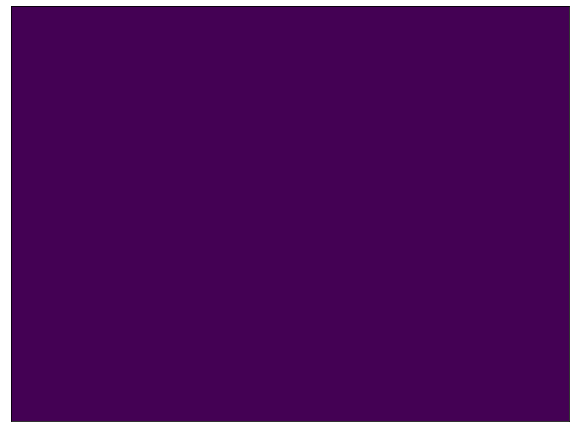

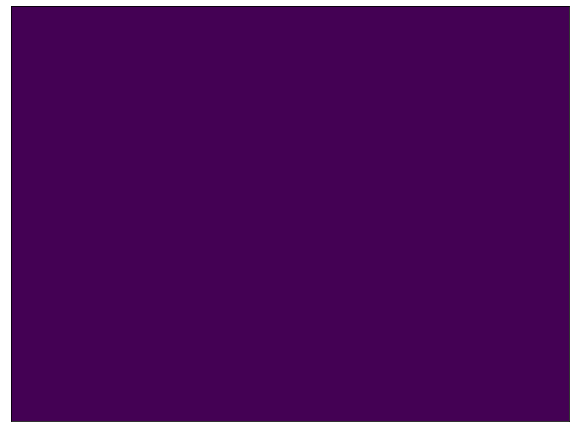

In [155]:
criterion = nn.CrossEntropyLoss()
criterion2 = tgm.losses.DiceLoss()
run_test_epochs(model,test_dataset,criterion,criterion2,batch_size=1)

In [166]:
import plotly.graph_objects as go

In [167]:
def create_figure():
  return go.Figure()
  
def plot_figure(fig, chart_data, title, x_title, y_title):  

  for dataset in chart_data:
    y_axis = [float(x) for x in dataset['y_data']]
    fig.add_scatter(
      y=y_axis,
      x=[x+1 for x in range(len(y_axis))],
      mode="lines+markers", 
      textposition="bottom center",
      name=dataset['label'],
      line={"color": dataset['color'], "width": 1}
    )

  fig.update_layout(
    title=title,
    width=1024,
    height=400,
    xaxis={"title": x_title},
    yaxis={"title": y_title, "tickformat": ".2f"},
    font=dict(
      family="Courier New, monospace",
      size=14,
      color="#7f7f7f"
    )
  )

In [168]:
fig = create_figure()

In [169]:
plot_figure(fig, [{"label":"Train Loss", "color": "#00f", "y_data": [0.08775,0.04274,0.03858,0.03645,0.03441,0.03300,0.03397,0.03278,0.03161,0.03116]}], "Loss Chart", "Epochs", "Value")

In [170]:
fig.show()